## Imports

In [1]:
from AlgoFCN import FeatureTracker

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm import tqdm

import os
import glob
import numpy as np
import cv2

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import glob
import copy


## Initials

In [ ]:
class LaSOTHorseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'img')
        self.bbox_file = os.path.join(root_dir, 'groundtruth.txt')
        self.occlusion_file = os.path.join(root_dir, 'full_occlusion.txt')
        self.out_of_view_file = os.path.join(root_dir, 'out_of_view.txt')

        # Load annotations
        self.bboxes = pd.read_csv(self.bbox_file, header=None)
        self.occlusions = pd.read_csv(self.occlusion_file, header=None).iloc[0]
        self.out_of_views = pd.read_csv(self.out_of_view_file, header=None).iloc[0]

    def __len__(self):
        return len(self.bboxes)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{idx+1:08d}.jpg')
        bbox = self.bboxes.iloc[idx].values
        occlusion = self.occlusions[idx]
        out_of_view = self.out_of_views[idx]

        sample = {'image_path': img_path, 'bbox': bbox, 'occlusion': occlusion, 'out_of_view': out_of_view}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example transform that converts images to tensor
class ToTensorTransform:
    def __call__(self, sample):
        return sample

In [ ]:
tracker = FeatureTracker()
# Example of using the dataset with DataLoader
horse_dataset = LaSOTHorseDataset(root_dir='/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/lasot/horse/horse-15',
                                   transform=ToTensorTransform())
# dataloader = DataLoader(horse_dataset, batch_size=1, shuffle= False)
dataloader = DataLoader(horse_dataset, batch_size=1, shuffle=False)
print(len(dataloader))

plottingFrames = []

for i, item in enumerate(dataloader):
    imagePath = item['image_path'][0]
    bbox = item['bbox'][0]
    occlusion = item['occlusion'][0]
    outOfView = item['out_of_view'][0]

    desRec = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
    desRec = [x.item() for x in desRec]
    isOnline = False
    __cpTracks, __kpMvmt, image_cv2 = tracker.process_frame(imagePath, i, desRec, isOnline)
    cvFrame = tracker.update_cvFrame(__cpTracks, image_cv2, i, desRec, _isOnline = False, pltTrackLines = True)

    plottingFrames.append(cvFrame)

    # if (not occlusion) or (not outOfView): 
    #     pass

    # print(f"Item {i+1}")
    # print(imagePath, bbox, occlusion, outOfView)

    # image = read_image(imagePath).permute(1, 2, 0) / 255  # Convert the image to the [0, 1] range

    # fig, ax = plt.subplots()
    # ax.imshow(image)
    # # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

    # ax.add_patch(rect)
    # plt.show()

    # Break after first batch just for demonstration
    if i > 20:
        break

In [ ]:
address = '/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/CNT_Growth_RK/exp1_gf_clahe'
files314_pathes = glob.glob(address +  '/* 314 -*.tif')


### Algorithm Functions

In [ ]:
tracker = FeatureTracker(ftExtractor = 'aliked', mx_keypoints = 1024, desired_device = 0)

plottingFrames = []
gr_exp_1_314 = []


for i, imagePath in tqdm(enumerate(files314_pathes)):
    # Get the base name of the file
    basename = os.path.basename(imagePath)
    # Remove 'exp1_gf_clahe/' from the beginning of the name
    orginal_name = basename.replace('gf_clh_', '')

    if i < 0:
        gr_exp_1_314.append((orginal_name, -1))
    elif i < 10:
        idx = i - 0
        desRec = [0, 0, 1024, 500]
        isOnline = False
        __cpTracks, __kpMvmt, image_cv2, _frmTracks = tracker.process_frame(imagePath, idx, desRec, isOnline)
        # First, filter out tracks with less than 3 keypoints to avoid modifying the dictionary during iteration
        # __cpTracks = {key: value for key, value in __cpTracks.items() if len(value) >= 3}

        # # Create a dictionary that maps track IDs to colors

        cvFrame = tracker.update_cvFrame(__cpTracks, image_cv2, _frmTracks, desRec, _isOnline = False)
        plottingFrames.append(cvFrame)

        nmGrowthrate = 0
        if __kpMvmt > 0:
            nmGrowthrate = np.log(__kpMvmt * 5) # conversion to nm and log scale 400px = 2um -> 1 px = 2um/400px = 5nm/px
        gr_exp_1_314.append((orginal_name, nmGrowthrate))
    if i >= 1350:
        gr_exp_1_314.append((orginal_name, -1))
    


    

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format

# Use the shape of the first image to get the frame size (width, height)
frame_size = (plottingFrames[0].shape[1], plottingFrames[0].shape[0])

# Create a VideoWriter object. Adjust FPS to your liking.
out = cv2.VideoWriter('clahe_output_video.mp4', fourcc, 1.0, frame_size)

for i in range(len(plottingFrames)):
    # Write the frame to the video
    out.write(plottingFrames[i])

# Release everything when job is finished
out.release()

# Optionally, display a message
print("The video was successfully saved!")

### Run the code


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: Generate some synthetic data for demonstration
# Let's assume these are your boundary features for each slice
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting each slice
# In a real scenario, you would loop through your slices
ax.contour3D(X, Y, Z, 50)

plt.show()

### Receptor Tracking

In [2]:
# address = '/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/RECEPTOR/RECEPTOR snr 7 density high/'
# address = 'exp2_gf_clahe/'
# image_paths = glob.glob(address +  '*.tif')
address = '/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/CNT_Growth_RK/exp3_gf_clahe/'

image_pathes = glob.glob(address +  'gf_clh_FS30363_6 (Channel 1) 323*.tif')
image_pathes = image_pathes[0:499] # 800
tracker = FeatureTracker(ftExtractor = 'aliked', mx_keypoints = 1024, desired_device = 3)
kp_lent_ornt_deltaXY_dic = {}
plottingFrames = []
desRec = [0, 0, 1024, 450]
growthTracks = {}
frameGrowthingTracksList = {}
idmmf = 0
for idx, imagePath in tqdm(enumerate(image_pathes)):
        frameGrowthingTracks = None
        tracks, kp_lent_ornt_deltaXY_list, image_cv2, _frmTracks, frameGrowthingTracks = tracker.process_frame(imagePath, idx, desRec, isOnline = False)
        cvFrame = tracker.update_cvFrame(tracks, image_cv2, _frmTracks, desRec, _isOnline = False)
        plottingFrames.append(cvFrame)
        kp_lent_ornt_deltaXY_dic[idx] = kp_lent_ornt_deltaXY_list
        # print(len(tracks), len(frameGrowthingTracks), print(idmmf))
        frameGrowthingTracksCopy = copy.deepcopy(frameGrowthingTracks)
        frameGrowthingTracksList[idmmf] = frameGrowthingTracksCopy
        idmmf = idmmf + 1

499it [12:18,  1.48s/it]


In [ ]:
print(frameGrowthingTracksList[5].items())

In [ ]:
for key, value in list(tracks.items()):
    if len(value) < 2:
        del tracks[key]

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format

# Use the shape of the first image to get the frame size (width, height)
frame_size = (plottingFrames[0].shape[1], plottingFrames[0].shape[0])

# Create a VideoWriter object. Adjust FPS to your liking.
out = cv2.VideoWriter('./results/orientation_paper/sift.mp4', fourcc, 2.0, frame_size)

for i in range(len(plottingFrames)):
    # Write the frame to the video
    out.write(plottingFrames[i])

# Release everything when job is finished
out.release()

# Optionally, display a message
print("The video was successfully saved!")

In [ ]:
import xml.etree.ElementTree as ET
import xml.dom.minidom

root = ET.Element("root")
track_contest = ET.SubElement(root, "TrackContestISBI2012", SNR="7", density="high", 
                              generationDateTime="Mon Feb 13 20:41:59 CET 2012", 
                              info="http://bioimageanalysis.org/track/", scenario="RECEPTOR")

idx = 0
for particle_id, detections in tracks.items():
    # if idx >= 727:
    #     break
    particle_element = ET.SubElement(track_contest, "particle")
    for detection in detections:
        t, (x, y) = detection
        # Format x and y with 3 decimal places
        formatted_x = "{:.3f}".format(float(x))
        formatted_y = "{:.3f}".format(float(y))
        ET.SubElement(particle_element, "detection", t=str(t), x=formatted_x, y=formatted_y, z="0")
    idx +=1
# Convert the ElementTree to a string and format it
dom = xml.dom.minidom.parseString(ET.tostring(root, 'utf-8'))
pretty_xml_as_string = dom.toprettyxml(indent="")

with open("./results/superpoint/superpoint_RECEPTOR_snr_7_density_high.xml", "w") as f:
    f.write(pretty_xml_as_string)

#### investigate Orientation and Length Tracks

In [ ]:
# kp_lent_ornt_dic_superpoint = kp_lent_ornt_deltaXY_dic
# kp_lent_ornt_dic_disk = kp_lent_ornt_deltaXY_dic
# kp_lent_ornt_dic_aliked = kp_lent_ornt_deltaXY_dic
kp_lent_ornt_dic_sift = kp_lent_ornt_deltaXY_dic

import json

# Save to file
with open('./results/orientation_paper/kp_lent_ornt_dic_aliked_win.json', 'w') as f:
    json.dump(kp_lent_ornt_dic_sift, f)

import json

# Retrieve from file
with open('./results/orientation_paper/kp_lent_ornt_dic_aliked.json', 'r') as f:
    kp_lent_ornt_deltaXY_dic = json.load(f)

In [ ]:


mean_ornt_list = []
std_ornt_list = []
mean_length_list = []
std_length_list = []
sum_delta_x_list = []
sum_delta_y_list = []

for i, (frmIdx, kp_lent_ornt_deltaXY_list) in enumerate(kp_lent_ornt_deltaXY_dic[0:49].items()):
    if(len(kp_lent_ornt_deltaXY_list) == 0):
        continue
    # orientations = [item[1] for item in kp_lent_ornt_deltaXY_list]
    # # Calculate the mean and standard deviation
    # mean_orientation = np.mean(orientations)
    # std_orientation = np.std(orientations)
    # mean_ornt_list.append(mean_orientation)
    # std_ornt_list.append(std_orientation)

    # lengthes = [item[0]*5 for item in kp_lent_ornt_deltaXY_list]
    # # Calculate the mean and standard deviation
    # mean_length = np.mean(lengthes)
    # std_length = np.std(lengthes)
    # mean_length_list.append(mean_length)
    # std_length_list.append(std_length)

    delta_xes = [item[2]*5 for item in kp_lent_ornt_deltaXY_list]
    delta_yes = [item[3]*5 for item in kp_lent_ornt_deltaXY_list]
    sum_delta_x_list.append(np.mean(delta_xes))
    sum_delta_y_list.append(np.mean(delta_yes))

total_delta_x = np.sum(sum_delta_x_list)
total_delta_y = np.sum(sum_delta_y_list)
print(total_delta_x, total_delta_y)


-778.2545634888864 44584.26243869016


KeyError: slice(0, 49, None)

In [ ]:
import matplotlib.pyplot as plt

# Plot the values
plt.plot(list(range(len(mean_length_list))), mean_length_list)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import math
# # Your signal with noise
# signal = np.random.normal(0, 1, 1000) + np.linspace(0, 10, 1000)
# Create an array of doubled indices
doubled_indices = np.arange(len(mean_length_list)) * 2
mean_ornt_list_degrees = [math.degrees(x) for x in mean_ornt_list]

# Apply a Gaussian filter to remove noise
smooth_signal = gaussian_filter1d(mean_ornt_list_degrees, 5)

# Plot the original and smoothed signals
plt.figure(figsize=(10, 6))
plt.plot(doubled_indices, mean_ornt_list_degrees, label='Original Signal')
plt.plot(doubled_indices, smooth_signal, label='Smoothed Signal', linewidth=4)

plt.xlabel('Frame Index', fontsize=16)  # Corrected x-axis label for clarity
plt.ylabel('Orientation (Degrees)', fontsize=16)  # Corrected y-axis label for clarity
plt.title('Mean of Orientation and its Filtered Gaussian Signal', fontsize=16, fontweight='bold')  # Improved title for clarity

plt.legend(fontsize=15, loc='upper left', ncol=4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure as a PDF file
plt.savefig('./results/orientation_paper/mean_gaussian.pdf', dpi=300)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import math

# Create an array of doubled indices
doubled_indices = np.arange(len(std_length_list)) * 2
# Apply a Gaussian filter to remove noise
smooth_signal = gaussian_filter1d(std_length_list, 5)

# Plot the original and smoothed signals
plt.figure(figsize=(10, 6))
plt.plot(doubled_indices, std_length_list, label='Original Signal')
plt.plot(doubled_indices, smooth_signal, label='Smoothed Signal', linewidth=4)

plt.xlabel('Time (Seconds)', fontsize=16)  # Corrected x-axis label for clarity
plt.ylabel('Standard Deviation of Track Length (nm)', fontsize=16)  # Corrected y-axis label for clarity
plt.title('Standard Deviation of Track Length and its Filtered Gaussian Signal', fontsize=16, fontweight='bold')  # Improved title for clarity

plt.legend(fontsize=15, loc='upper left', ncol=4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure as a PDF file
plt.savefig('./results/orientation_paper/std_length_gaussian.pdf', dpi=300)

plt.show()

### plot growing tracks

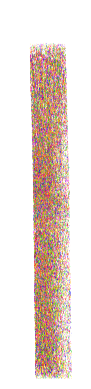

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

trackColors = tracker.generate_manual_colors()
_cvFrame = np.ones((10300, 2000, 3), dtype=np.uint8) * 255
frameGrowthingTracks = frameGrowthingTracksList[499]
for _idx, (trackId, frm_keypoints) in enumerate(frameGrowthingTracks.items()):

    if len(frm_keypoints) >= 2:
        color = trackColors[trackId % len(trackColors)]
        # color = (0,0,0)
        # Iterate until the second-to-last item to avoid IndexError
        for idx in range(len(frm_keypoints) - 1):
            startPoint = tracker.toInt(frm_keypoints[idx][1])
            endPoint = tracker.toInt(frm_keypoints[idx + 1][1])
            startPoint = (startPoint[0], _cvFrame.shape[0] - startPoint[1])
            endPoint = (endPoint[0], _cvFrame.shape[0] - endPoint[1])
            # Draw line for all but the last point, where a circle will be drawn
            cv2.line(_cvFrame, startPoint, endPoint, color, 2)
            
        # # Draw a circle at the last point
        # lastPoint = tracker.toInt(frm_keypoints[-1][1])
        # cv2.circle(_cvFrame, lastPoint, 3, color, -1)
# Convert the image from BGR to RGB
image = cv2.cvtColor(_cvFrame, cv2.COLOR_BGR2RGB)

# Display the image with plt
fig = plt.figure()
plt.axis('off')

plt.imshow(image)
# Invert the y-axis
# plt.gca().invert_yaxis()
plt.show()
fig.savefig('results/image_323_50.png', dpi=300)
# Save the image
# plt.imsave('image.png', image)

In [ ]:
import cv2
import numpy as np

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
out = cv2.VideoWriter('output_314.mp4', fourcc, 2.0, (3000, 3000))

# Create 10 white frames and write them to the video
for id, frameGrowthingTracks in enumerate(frameGrowthingTracksList):
    frameGrowthingTracks = frameGrowthingTracksList[id]
    frame = np.ones((3000, 3000, 3), dtype=np.uint8) * 255
    for _idx, (trackId, frm_keypoints) in enumerate(frameGrowthingTracks.items()):

        if len(frm_keypoints) >= 2:
            # color = trackColors[trackId % len(trackColors)]
            color = (0,0,0)  # Overriding color to black

            for idx in range(len(frm_keypoints) - 1):
                startPoint = tracker.toInt(frm_keypoints[idx][1])
                endPoint = tracker.toInt(frm_keypoints[idx + 1][1])
                startPoint = (startPoint[0], frame.shape[0] - startPoint[1])
                endPoint = (endPoint[0], frame.shape[0] - endPoint[1])
                cv2.line(frame, startPoint, endPoint, color, 2)

    out.write(frame)


# Release the VideoWriter
out.release()

In [ ]:
import moviepy.editor as mp

# Load the original video
video = mp.VideoFileClip("output_314.mp4")

# Reduce the size by reducing the resolution (here, we reduce the width to 480px and maintain aspect ratio)
target_width = 480
aspect_ratio = video.size[1] / video.size[0]
target_height = round(target_width * aspect_ratio)

# Resize the video
resized_video = video.resize(newsize=(target_width, target_height))

# Write the resized video to a file
resized_video.write_videofile("resized_video.mp4")

In [ ]:
import os

# Specify the directory containing the images
directory = "exp2_gf_clahe/"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".tif"):  # Check if the file is a .tif image
        # Split the filename on spaces and take the last part
        new_name = filename.split()[-1]
        # Construct the full old and new file paths
        old_file = os.path.join(directory, filename)
        new_file = os.path.join(directory, new_name)
        # Rename the file
        os.rename(old_file, new_file)
        print(f"Renamed '{filename}' to '{new_name}'")

print("Renaming complete.")